# Sequence-to-Sequence Learning

This homework is modified from the PyTorch seq2seq tutorial. We use the dataset and dataloading functions given in their tutorial, but change French-to-English translation to English-to-French translation.

In this project we will implement a neural network to translate from
English to French.

::
    [KEY: > input, = target, < output]

    > he is painting a picture .
    = il est en train de peindre un tableau .
    < il est en train de peindre un tableau .

    > why not try that delicious wine ?
    = pourquoi ne pas essayer ce vin delicieux ?
    < pourquoi ne pas essayer ce vin delicieux ?

... to varying degrees of success.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Set seed for reproducibility
SEED = 0

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Data Loading
The following functions are directly copied from their tutorial. For details of what they are doing, please refer to the original tutorial

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    # Lang class: Manages vocabulary mapping between words and indices
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8'). \
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    # Data filtering: Keeps only sentence pairs under MAX_LENGTH words with specific English prefixes
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', False)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
['we re on the same side', 'nous sommes du meme cote']


In [51]:
def indexesFromSentence(lang, sentence):
    # Handle out-of-vocabulary words by skipping them
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def build_tensors(input_lang, output_lang, pairs, max_len=MAX_LENGTH):
    n = len(pairs)
    input_ids = np.zeros((n, max_len), dtype=np.int32)  # 0 will act as PAD
    target_ids = np.zeros((n, max_len), dtype=np.int32)  # 0 will act as PAD (and ignore_index in loss)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp) + [EOS_token]
        tgt_ids = indexesFromSentence(output_lang, tgt) + [EOS_token]
        input_ids[idx, :min(len(inp_ids), max_len)] = inp_ids[:max_len]
        target_ids[idx, :min(len(tgt_ids), max_len)] = tgt_ids[:max_len]

    X = torch.LongTensor(input_ids).to(device)
    Y = torch.LongTensor(target_ids).to(device)
    return X, Y


def get_dataloader(batch_size, seed=0):
    # Set random seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    input_lang, output_lang, pairs = prepareData('eng', 'fra', False)

    # Split dataset into 80% train and 20% test
    random.shuffle(pairs)
    split_idx = int(0.8 * len(pairs))
    train_pairs = pairs[:split_idx]
    test_pairs = pairs[split_idx:]

    X_train, Y_train = build_tensors(input_lang, output_lang, train_pairs, MAX_LENGTH)
    X_test, Y_test = build_tensors(input_lang, output_lang, test_pairs, MAX_LENGTH)
    train_loader = DataLoader(TensorDataset(X_train, Y_train),
                              batch_size=batch_size, shuffle=True)
    test_data = (X_test, Y_test, test_pairs)

    return input_lang, output_lang, train_loader, test_data

## Part (a): Implement Encoder

Implement the EncoderRNN. You are allowed to use `nn` functions from PyTorch. Please use embedding layer + dropout + GRU cell. You can follow the original architecture from the Sutskever et al. "Sequence to Sequence Learning with Neural Network." 2014.

In [28]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.cell = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.cell(embedded)
        return output, hidden

## Part (b): Implementing Decoder

Implement the DecoderRNN. Again you are allowed to use `nn` functions from PyTorch. Please use embedding + ReLU + GRU + linear output layer. You can follow the original architecture from the Sutskever et al. "Sequence to Sequence Learning with Neural Network." 2014.

In [35]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()

        ## TODO: YOUR CODE HERE
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.cell = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output.unsqueeze(1))

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self, input, hidden):
        embedded = self.relu(self.embedding(input))  # (batch_size, 1, hidden_size)
        output, hidden = self.cell(embedded, hidden)  # output: (batch_size, 1, hidden_size), hidden: (1, batch_size, hidden_size)
        output = self.out(output.squeeze(1))
        return output, hidden

## Part (c): Training and Evaluate

Use the provided code to train the Encoder-Decoder architectures. To get credit for this part, simply show the outputs of the prediction

In [36]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
                decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_norm=1.0)

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index=0)  # Ignore padding index in loss

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                         epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


def inference(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)  # (1,T,1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            if idx.item() != 0:  # Skip PAD/SOS id
                decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words


def evaluateRandomly(encoder, decoder, test_pairs, n=10):
    for i in range(n):
        src, tgt = random.choice(test_pairs)
        print('>', src)
        print('=', tgt)
        output_words = inference(encoder, decoder, src, input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [37]:
hidden_size = 128
batch_size = 32
n_epochs = 80

input_lang, output_lang, train_dataloader, test_data = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# It takes ~4min to train for 80 epochs on GPU. Feel free to increase n_epochs.
losses = train(train_dataloader, encoder, decoder, n_epochs, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
eng 2991
fra 4601
0m 19s (- 4m 52s) (5 6%) 3.1979
0m 38s (- 4m 26s) (10 12%) 1.8508
0m 56s (- 4m 6s) (15 18%) 1.2729
1m 15s (- 3m 45s) (20 25%) 0.9224
1m 34s (- 3m 27s) (25 31%) 0.6917
1m 52s (- 3m 7s) (30 37%) 0.5385
2m 11s (- 2m 48s) (35 43%) 0.4330
2m 29s (- 2m 29s) (40 50%) 0.3602
2m 48s (- 2m 10s) (45 56%) 0.3101
3m 6s (- 1m 51s) (50 62%) 0.2725
3m 25s (- 1m 33s) (55 68%) 0.2479
3m 43s (- 1m 14s) (60 75%) 0.2280
4m 2s (- 0m 55s) (65 81%) 0.2136
4m 20s (- 0m 37s) (70 87%) 0.2022
4m 39s (- 0m 18s) (75 93%) 0.1940
4m 58s (- 0m 0s) (80 100%) 0.1870


<Figure size 640x480 with 0 Axes>

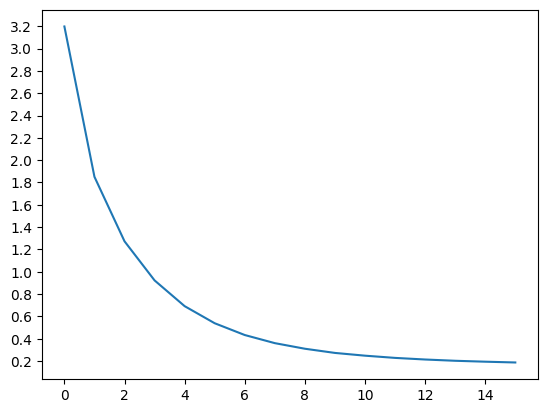

In [38]:
showPlot(losses)

In [39]:
encoder.eval()
decoder.eval()
X_test, Y_test, test_pairs = test_data
evaluateRandomly(encoder, decoder, test_pairs)

> you re a bad liar
= vous mentez mal
< tu ca ca il il il il il il il

> we re newcomers
= nous sommes des nouveaux venus
< nous nous la les les il il il il il

> you re really selfish
= vous etes vraiment egoiste
< tu on il on il il il il il il

> you are good
= tu es bon
< tu vous vous ca <EOS>

> we re tempting fate
= nous tentons le diable
< nous nous nous il il il il il il il

> you re very busy
= tu es tres occupe
< vous on il on on il il il il il

> you re stuck
= vous etes plantee
< vous il il il il il il il il il

> you re moody
= tu es lunatique
< tu il il il il il il il il il

> i m a bit of a reader myself
= je suis moi meme un peu lecteur
< j il il il il il il il il il

> i am exhausted
= je suis epuisee
< je je j j j j j j j j



## Part (d): Quantitative evaluation using BLEU score

**Note**: You don't need to consider multiple references for each sentence, for simplicity.


In [40]:
# Install sacrebleu library for corpus-level BLEU score calculation
!pip -q install sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.3 MB/s eta 0:00:00


In [41]:
import sacrebleu

def corpus_bleu_score(hypotheses, references):
    hyps = [" ".join(h) for h in hypotheses]
    refs = [[" ".join(r) for r in references]]
    return sacrebleu.corpus_bleu(hyps, refs).score

In [43]:
# quantitative BLEU on the whole test split
X_test, Y_test, test_pairs = test_data
hyps, refs = [], []
with torch.no_grad():
    for (src, tgt) in test_pairs:
        hyp_tokens = [w for w in inference(encoder, decoder, src, input_lang, output_lang) if w != '<EOS>']
        ref_tokens = tgt.split(' ')[:MAX_LENGTH - 1]  # same truncation policy as tensors
        hyps.append(hyp_tokens)
        refs.append(ref_tokens)
result_bleu = corpus_bleu_score(hyps, refs)
print(f"Corpus BLEU on test: {result_bleu:.2f}")

Corpus BLEU on test: 0.08


## Part (e): Compare outputs from: your model, a choosen LLM, and Google Translate

Choose 5 English sentences from the test set (or write 5 new ones by your own, remember to generate reference sentences for each of them). Translate them using: your trained model, one LLM of your choice (report the model name, version, and your prompt), and [Google Translate](https://translate.google.com/?sl=en&tl=fr&op=translate). Show original sentences, your model's output, LLM output, and Google Translate output. Compare them using [BLEU](https://huggingface.co/spaces/evaluate-metric/bleu) score. Which one is the best? Which one is the worst? List three points that would improve the model.

**Note**: You don't need to consider multiple references for each sentence, for simplicity.



In [44]:
# Import bleu function
# Installs into the exact Python interpreter used by the notebook, then verifies import and version.
import sys, subprocess

print("Python executable:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "evaluate", "sacrebleu"])

# After install, you normally must restart the kernel. Try importing; if it still fails, restart the kernel.
import importlib

try:
    evaluate = importlib.import_module("evaluate")
    print("evaluate version:", getattr(evaluate, "__version__", "unknown"))
    bleu = evaluate.load("bleu")
    print("Loaded BLEU successfully")
except Exception as e:
    print("Import failed (restart kernel if needed):", repr(e))

Python executable: /usr/bin/python3
evaluate version: 0.4.6


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded BLEU successfully


In [70]:
# Select 5 random pairs from the test set with a seed for reproducibility
X_test, Y_test, test_pairs = test_data
random.seed(SEED) # Use the predefined SEED for reproducibility
random_test_pairs = random.sample(test_pairs, 5)

english_sentences = [pair[0] for pair in random_test_pairs]
manual_translations = [pair[1] for pair in random_test_pairs]

In [73]:
english_sentences, manual_translations

(['i m done thinking',
  'i m fighting',
  'we re dancing',
  'i am seeing mary this afternoon',
  'you re really selfish'],
 ['j en ai marre de penser',
  'je me bats',
  'nous sommes en train de danser',
  'je vois mary cette apres midi',
  'vous etes vraiment egoiste'])

In [74]:
import sys, subprocess
import random # Import random to select test pairs

print("Python executable:", sys.executable)
import importlib

try:
    evaluate = importlib.import_module("evaluate")
    print("evaluate version:", getattr(evaluate, "__version__", "unknown"))
    bleu = evaluate.load("bleu")
    print("Loaded BLEU successfully")
except Exception as e:
    print("Import failed (restart kernel if needed):", repr(e))

# Gemini translations (FILL IN WITH YOUR GEMINI TRANSLATIONS)
# Prompt used: "Translate the following English sentences to French:" followed by the English sentences.
gemini_translations = [
    "J'ai fini de penser",
    'Je me bats',
    'On danse',
    'Je vois Mary cet apres-midi',
    'Tu es vraiment egoiste'
]

# Google translations (LEAVE BLANK FOR USER TO FILL)
google_translations = [
    "J'en ai fini de réfléchir",
    'je me bats',
    'nous dansons',
    'Je vois Mary cet après-midi',
    'Tu es vraiment égoïste'
]

# Get predictions from the trained model
model_predictions = []
for sentence in english_sentences:
    predicted_tokens = [w for w in inference(encoder, decoder, sentence, input_lang, output_lang) if w != '<eos>']
    model_predictions.append(' '.join(predicted_tokens))

# Calculate BLEU scores
model_bleu = bleu.compute(predictions=model_predictions, references=manual_translations)
gemini_bleu = bleu.compute(predictions=gemini_translations, references=manual_translations)
google_bleu = bleu.compute(predictions=google_translations, references=manual_translations)

# Display BLEU scores
print("\nBLEU Scores:")
print(f"Trained Model: {model_bleu['bleu']:.4f}")
print(f"Gemini: {gemini_bleu['bleu']:.4f}")
print(f"Google Translate: {google_bleu['bleu']:.4f}")

Python executable: /usr/bin/python3
evaluate version: 0.4.6
Loaded BLEU successfully

BLEU Scores:
Trained Model: 0.0000
Gemini: 0.0000
Google Translate: 0.0000


## Part (f): Change to LSTM cell
Try using the `nn.LSTM` cell instead of the `nn.GRU` cell, and retrain the model. Is the model performing better or worse? Show us any plots or objective metrics that can back-up your claim.

In [60]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.cell = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.cell(embedded) # LSTM returns both hidden and cell state
        return output, hidden # We only need to return the hidden state for the decoder for now

In [61]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.cell = nn.LSTM(hidden_size, hidden_size, batch_first=True) # Changed to LSTM
        self.out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = (encoder_hidden, torch.zeros_like(encoder_hidden)) # Initialize cell state for LSTM
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output.unsqueeze(1))

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self, input, hidden):
        embedded = self.relu(self.embedding(input))  # (batch_size, 1, hidden_size)
        output, hidden = self.cell(embedded, hidden)  # output: (batch_size, 1, hidden_size), hidden: ((1, batch_size, hidden_size), (1, batch_size, hidden_size))
        output = self.out(output.squeeze(1))
        return output, hidden # Return both hidden and cell states

In [62]:
# Use the existing training code to train the modified Encoder-Decoder model with LSTM cells.
encoder_lstm = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_lstm = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# It takes ~4min to train for 80 epochs on GPU. Feel free to increase n_epochs.
losses_lstm = train(train_dataloader, encoder_lstm, decoder_lstm, n_epochs, print_every=5, plot_every=5)

0m 23s (- 5m 53s) (5 6%) 3.5738
0m 46s (- 5m 25s) (10 12%) 2.3875
1m 8s (- 4m 55s) (15 18%) 1.8655
1m 30s (- 4m 30s) (20 25%) 1.5095
1m 51s (- 4m 5s) (25 31%) 1.2459
2m 12s (- 3m 41s) (30 37%) 1.0450
2m 34s (- 3m 19s) (35 43%) 0.8825
2m 56s (- 2m 56s) (40 50%) 0.7497
3m 18s (- 2m 34s) (45 56%) 0.6398
3m 40s (- 2m 12s) (50 62%) 0.5484
4m 1s (- 1m 49s) (55 68%) 0.4737
4m 23s (- 1m 27s) (60 75%) 0.4119
4m 45s (- 1m 5s) (65 81%) 0.3621
5m 7s (- 0m 43s) (70 87%) 0.3229
5m 28s (- 0m 21s) (75 93%) 0.2893
5m 49s (- 0m 0s) (80 100%) 0.2638


In [65]:
encoder_lstm.eval()
decoder_lstm.eval()
X_test, Y_test, test_pairs = test_data
hyps_lstm, refs_lstm = [], []
with torch.no_grad():
    for (src, tgt) in test_pairs:
        hyp_tokens_lstm = [w for w in inference(encoder_lstm, decoder_lstm, src, input_lang, output_lang) if w != '<eos>']
        hyps_lstm.append(" ".join(hyp_tokens_lstm)) # sacrebleu expects strings for hypotheses
        refs_lstm.append([tgt]) # sacrebleu expects a list of lists for references

# Calculate BLEU score using sacrebleu.corpus_bleu
result_bleu_lstm = sacrebleu.corpus_bleu(hyps_lstm, refs_lstm).score
print(f"Corpus BLEU on test for LSTM model: {result_bleu_lstm:.2f}")

# Compare with GRU model's BLEU score
print(f"Corpus BLEU on test for GRU model: {result_bleu:.2f}")

Corpus BLEU on test for LSTM model: 5.93
Corpus BLEU on test for GRU model: 0.08


## Discussion

The BLEU score when we used the LSTM model is much much higher than we use the GRU.

LSTM likely outperformed the GRU because the complexity of the data and the length of the sequences benefited from the LSTM's dedicated memory cell and three-gate architecture. The GRU's simpler, two-gate design (reset and update) merges the hidden state and memory functions, which is efficient but can struggle with very long-range dependencies or the nuanced information gating required in complex translation. The LSTM's ability to explicitly control what information to remember, forget, and output through its separate input, forget, and output gates provided a more robust mechanism for preserving critical context over many time steps within the encoder-decoder framework.